In [1]:
import json
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
import string
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler


In [2]:
#Read raw txt file 
def read_file(file):   
    rawdata = [] 
    tweets_file = open(file, "r") 
    for line in tweets_file:
        tweet = json.loads(line)
        rawdata.append(tweet)
    tweets_file.close()
    return rawdata
rawdata = read_file('t1.txt')

In [3]:
#Extract tweets text and assign labels 1-retweeted 0-no retweeted
def extract_text(data):    
    temp_data = pd.DataFrame(data, columns = ['text', 'retweeted_status', 'lang']) 
    alltweets = {}
    for x in temp_data['text']: 
        if x.startswith("RT"): 
            alltweets.update({x: 1})
        else:
            alltweets.update({x: 0})
    return alltweets
    
text = extract_text(rawdata)


In [4]:
df = pd.DataFrame(list(text.items()), columns=['tweet', 'label'])

In [5]:
def transform(tweet):   #Remove special characters, punctuation and stop words
    tknzr = TweetTokenizer()
    tweet = re.sub('http\S+', '', tweet)
    tweet = re.sub('@\S+', '', tweet)
    tweet = re.sub('#\S+', '', tweet) 
    tweet = tweet.replace('RT', '')
    tweet = tweet.replace('\'re', ' are')        
    tweet = tweet.strip()
    tweet = tweet.lower()
    tokens = tknzr.tokenize(tweet) 
    alpha_token = [word for word in tokens if word.isalpha()]
    remove_punc = [word for word in alpha_token if word not in string.punctuation]
    remove_stop = [word for word in remove_punc if word not in stopwords.words('english')]
    return ' '.join(remove_stop)
    
df['clean'] = df['tweet'].apply(transform)

In [6]:
#remove duplicates
df = df.drop_duplicates()

#remove null
df = df[pd.notnull(df['clean'])]

In [7]:
def find_verb(tweets):     #Find the verb for transforming to stem purpose
    tknzr = TweetTokenizer()
    stemverb = set()
    for sentence in tweets:
        terms = tknzr.tokenize(sentence) 
        tagged_terms = pos_tag(terms)
        for word in tagged_terms:
            if word[1].startswith('VBD') or word[1].startswith('VB') or word[1].startswith('VBP') or word[1].startswith('VBZ') or word[1].startswith('VBG') or word[1].startswith('VBN'):
                stemverb.add(word[0])
    return stemverb
    
verb = find_verb(list(df['clean']))

In [8]:
def find_stem(tweets, verb):    #Transform each word to its stem
    tknzr = TweetTokenizer()
    wnl = WordNetLemmatizer()
    stems = []       
    for sentence in tweets:
        terms = tknzr.tokenize(sentence)
        stem = []
        for word in terms:                
            if word in verb:
                word = wnl.lemmatize(word, 'v')
            else:
                word = wnl.lemmatize(word)
            stem.append(word)
            stem_merge = ' '.join(stem)
        stems.append(stem_merge)
    return stems 

df['clean'] = find_stem(list(df['clean']), verb)

In [9]:
df[df['label'] == 1].head()

,tweet,label,clean
0,RT @BelugaSolar: groSolar and CMS Energy begin...,1,grosolar cm energy begin operation new mw wisc...
2,RT @FoxNews: Californians urged to save energy...,1,californian urge save energy solar eclipse red...
6,RT @YaleE360: Wind &amp; #solar energy prove r...,1,wind energy prove reliable yet trump proposes ...
8,RT @Energy_Nature_: Huge solar station: “Topaz...,1,huge solar station topaz
10,RT @melanie_coutts: #stopadani #auspol There g...,1,go coal company donation libs finish


In [10]:
df[df['label'] == 0].head()

,tweet,label,clean
1,"Curated HedgeBz | Solar, wind, and nuclear eac...",0,curated hedgebz solar wind nuclear provide ene...
3,India cancels plans for huge coal power statio...,0,india cancel plan huge coal power station sola...
4,Seminole Electric Cooperative to supply solar ...,0,seminole electric cooperative supply solar ene...
5,What a beautiful energy-generation machine! ht...,0,beautiful machine
7,"Say, what??? Sweet! https://t.co/Mzh31AE3o8",0,say sweet


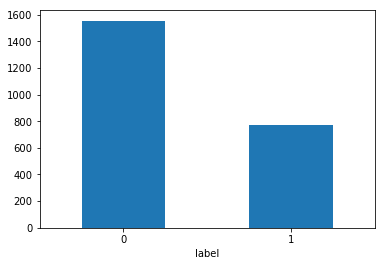

In [11]:
#check class balance
import matplotlib.pyplot as plt
df.groupby('label').tweet.count().plot('bar', rot = 0)
plt.show()

In [81]:
#split the train and test data randomly
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df['clean'], df['label'], df.index, test_size=0.33, random_state=0)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X_train)
features.shape

(1557, 551)

In [83]:
test_features = tfidf.transform(X_test)

In [84]:
#Oversampling the minority
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(features, y_train)

In [85]:
#use random forest classification algorithm
rf = RandomForestClassifier(n_estimators=20, min_samples_split = 40)
rf.fit(X_resampled,  y_resampled)
rf_scores = cross_val_score(rf, X_resampled, y_resampled, cv = 5)
print(rf_scores)
rf_p = rf.predict(test_features)
rf.score(test_features, y_test)

[ 0.67718447  0.66585366  0.71463415  0.75365854  0.7195122 ]


0.5958279009126467

In [86]:
#use gridsearch to find the best parameter for svm
from sklearn.svm import SVC
svm = SVC()
parameters = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10]}
from sklearn.model_selection import GridSearchCV
svm_cv = GridSearchCV(svm, parameters, cv=2)
svm_cv.fit(X_resampled, y_resampled)
print(svm_cv.best_params_)
print(svm_cv.best_score_)

{'C': 10, 'gamma': 1}
0.716374269006


In [87]:
#use svm classification algorithm
svm = SVC(C = 10, gamma = 1)
svc = svm.fit(X_resampled, y_resampled)
svc_p = svc.predict(test_features)
svc.score(test_features, y_test)

0.60756192959582789

In [89]:
#use logistic regression classification alogorithm
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_resampled, y_resampled)
logreg_p = logreg.predict(test_features)
logreg.score(test_features, y_test)

0.61016949152542377

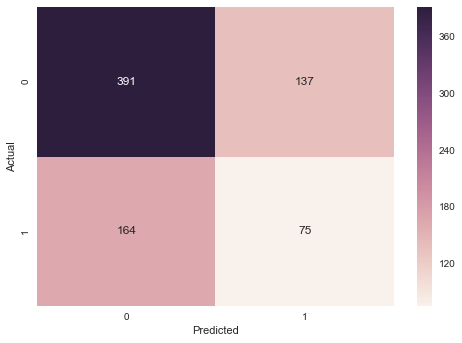

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, svc_p)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [91]:
#get feature importance
#find out which words contribute more to the retweet classification

#get the feature names
terms = tfidf.get_feature_names()
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=terms, 
                          columns=["Importance"])
importance = importance.sort_values("Importance", ascending = False)
print(importance.iloc[:20])

               Importance
solar            0.038635
energy           0.026356
solar energy     0.016038
california       0.014323
eclipse          0.013179
power            0.012085
solar eclipse    0.011646
solar power      0.011528
project          0.010040
latest           0.009819
wind             0.009402
daily            0.009192
look             0.008710
green            0.008503
panel            0.007999
ht               0.007564
year             0.007508
clean energy     0.007104
solar panel      0.007030
make             0.006474


In [92]:
text_original_text = df.loc[indices_test]['tweet']

In [93]:
df2 = pd.DataFrame({'tweet': text_original_text, 'clean': X_test, 'actual': y_test, 'predicted': svc_p})

In [94]:
df2[(df2['actual'] == 1) & (df2['predicted'] == 0)].head()

,actual,clean,predicted,tweet
1349,1,many people overestimate solar energy potentia...,0,RT @pablorodas: Many people overestimate the s...
1972,1,u save fortune solar wind energy positive exte...,0,RT @IRENA: US saving a fortune through solar &...
57,1,india cancel plan huge coal power station sola...,0,RT @watt_shane: India cancels plans for huge c...
1382,1,chair necker island event,0,RT @PowerLedger_io: Our Chair @msjemmagreen wi...
1358,1,wind solar energy provide positive externality...,0,RT @WRIClimate: Wind &amp; solar energy provid...


In [95]:
df2[(df2['actual'] == 0) & (df2['predicted'] == 1)].head()

,actual,clean,predicted,tweet
2152,0,solar house build chicago head energy competit...,1,Solar House Built in Chicago Heads to Energy C...
69,0,solar energy news,1,Solar Energy News is out! https://t.co/huhQYvJCOk
2223,0,last year industry employ many americans coal ...,1,“Last year the #solar industry employed many m...
2050,0,household pay solar energy report,1,Households should be paid for their solar ener...
602,0,big loser eclipse solar panel,1,@realDonaldTrump @IvankaTrump https://t.co/sWb...
